In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:


import h5py

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

with h5py.File(h5_path, "r") as f:
    g = f["0Nm_Normal"]
    print("Keys dentro de 0Nm_Normal:", list(g.keys()))

    for key in g.keys():
        obj = g[key]
        print(f"{key} → type={type(obj)}")


Keys dentro de 0Nm_Normal: ['acoustic', 'external', 'vibration']
acoustic → type=<class 'h5py._hl.group.Group'>
external → type=<class 'h5py._hl.group.Group'>
vibration → type=<class 'h5py._hl.group.Group'>


In [ ]:
with h5py.File(h5_path, "r") as f:
    g = f["0Nm_Normal"]["vibration"]["accel_1"]
    print("Keys dentro de 0Nm_Normal/vibration/accel_1:", list(g.keys()))

    for key in g.keys():
        obj = g[key]
        print(f"{key} → type={type(obj)}")


Keys dentro de 0Nm_Normal/vibration/accel_1: ['signal_sync']
signal_sync → type=<class 'h5py._hl.dataset.Dataset'>


In [ ]:
with h5py.File(h5_path, "r") as f:
    data = f["0Nm_Normal"]["vibration"]["accel_1"]["signal_sync"][:1000]  # primeros 1000 samples
    print("Shape de accel_1:", data.shape)


Shape de accel_1: (1000,)


In [ ]:
import h5py

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

def print_h5_tree(name, obj):
    """Imprime la estructura de un archivo HDF5"""
    if isinstance(obj, h5py.Group):
        print(f"📂 Grupo: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"   📄 Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")

with h5py.File(h5_path, "r") as f:
    f.visititems(print_h5_tree)


📂 Grupo: 0Nm_BPFI_03
📂 Grupo: 0Nm_BPFI_03/acoustic
   📄 Dataset: 0Nm_BPFI_03/acoustic/signal_sync, shape=(1536000,), dtype=float64
📂 Grupo: 0Nm_BPFI_03/external
📂 Grupo: 0Nm_BPFI_03/external/current
   📄 Dataset: 0Nm_BPFI_03/external/current/signal_sync, shape=(1536492,), dtype=float64
📂 Grupo: 0Nm_BPFI_03/external/extra
   📄 Dataset: 0Nm_BPFI_03/external/extra/signal_sync, shape=(1536492,), dtype=float64
📂 Grupo: 0Nm_BPFI_03/external/temperature
   📄 Dataset: 0Nm_BPFI_03/external/temperature/signal_sync, shape=(1536492,), dtype=float64
📂 Grupo: 0Nm_BPFI_03/vibration
📂 Grupo: 0Nm_BPFI_03/vibration/accel_1
   📄 Dataset: 0Nm_BPFI_03/vibration/accel_1/signal_sync, shape=(1536012,), dtype=float64
📂 Grupo: 0Nm_BPFI_03/vibration/accel_2
   📄 Dataset: 0Nm_BPFI_03/vibration/accel_2/signal_sync, shape=(1536012,), dtype=float64
📂 Grupo: 0Nm_BPFI_10
📂 Grupo: 0Nm_BPFI_10/acoustic
   📄 Dataset: 0Nm_BPFI_10/acoustic/signal_sync, shape=(1536000,), dtype=float64
📂 Grupo: 0Nm_BPFI_10/external
📂 Grupo: 

In [ ]:
import h5py
import numpy as np

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

X_vib, X_acoustic, X_ext, y = [], [], [], []

with h5py.File(h5_path, "r") as f:
    for cond in f.keys():
        g = f[cond]

        try:
            # Vibración
            v1 = g["vibration"]["accel_1"]["signal_sync"][:].astype(np.float32)
            v2 = g["vibration"]["accel_2"]["signal_sync"][:].astype(np.float32)
            if len(v1) == 0 or len(v2) == 0:
                continue
            min_len_vib = min(len(v1), len(v2))
            vib = np.stack([v1[:min_len_vib], v2[:min_len_vib]], axis=0)

            # Acústico
            if "acoustic" in g:
                a = g["acoustic"]["signal_sync"][:].astype(np.float32)
                if len(a) == 0:
                    a = np.zeros(min_len_vib, dtype=np.float32)
            else:
                a = np.zeros(min_len_vib, dtype=np.float32)

            # Externos
            cur = g["external"]["current"]["signal_sync"][:].astype(np.float32)
            ext = g["external"]["extra"]["signal_sync"][:].astype(np.float32)
            tmp = g["external"]["temperature"]["signal_sync"][:]
            if len(cur) == 0 or len(ext) == 0:
                continue
            if len(tmp) == 0:
                tmp = np.zeros(len(cur), dtype=np.float32)
            else:
                tmp = tmp.astype(np.float32)

            min_len_ext = min(len(cur), len(ext), len(tmp))
            cur, ext, tmp = cur[:min_len_ext], ext[:min_len_ext], tmp[:min_len_ext]
            ext_all = np.stack([cur, ext, tmp], axis=0)

            # Longitud mínima del grupo
            min_len_group = min(min_len_vib, len(a), min_len_ext)

            # Recortar
            vib = vib[:, :min_len_group]
            a = a[:min_len_group]
            ext_all = ext_all[:, :min_len_group]

            # Guardar
            X_vib.append(vib)
            X_acoustic.append(a)
            X_ext.append(ext_all)
            y.append(cond)  # 👉 Guardamos el nombre real, no el índice

        except Exception as e:
            print(f"Saltando {cond} por error: {e}")

# =====================
# Recorte global
# =====================
min_len_all = min(
    min(x.shape[1] for x in X_vib),
    min(len(a) for a in X_acoustic),
    min(x.shape[1] for x in X_ext)
)

print("Longitud mínima global:", min_len_all)

X_vib = np.array([x[:, :min_len_all] for x in X_vib])
X_acoustic = np.array([a[:min_len_all] for a in X_acoustic])
X_ext = np.array([x[:, :min_len_all] for x in X_ext])

# =====================
# Crear mapping de clases
# =====================
unique_labels = sorted(set(y))  # nombres únicos de clases
label_map = {name: idx for idx, name in enumerate(unique_labels)}

# Reemplazar y con índices
y_idx = np.array([label_map[name] for name in y])

print("Número de clases:", len(unique_labels))
print("Nombres de clases:")
for idx, name in enumerate(unique_labels):
    print(f"{idx}: {name}")

# =====================
# Resultado final listo
# =====================
print("X_vib:", X_vib.shape)
print("X_acoustic:", X_acoustic.shape)
print("X_ext:", X_ext.shape)
print("y:", y_idx.shape)

# Guardar para usar luego en entrenamiento
np.savez_compressed(
    "dataset_motor_fuzzy.npz",
    X_vib=X_vib,
    X_acoustic=X_acoustic,
    X_ext=X_ext,
    y=y_idx,
    label_names=np.array(unique_labels)  # 👉 Guardamos los nombres reales
)

print("Dataset guardado en dataset_motor_fuzzy.npz")


Longitud mínima global: 1536000
Número de clases: 36
Nombres de clases:
0: 0Nm_BPFI_03
1: 0Nm_BPFI_10
2: 0Nm_BPFI_30
3: 0Nm_Misalign_01
4: 0Nm_Misalign_03
5: 0Nm_Misalign_05
6: 0Nm_Normal
7: 0Nm_Unbalance_0583mg
8: 0Nm_Unbalance_1169mg
9: 0Nm_Unbalance_1751mg
10: 0Nm_Unbalance_2239mg
11: 0Nm_Unbalance_3318mg
12: 2Nm_BPFI_03
13: 2Nm_BPFI_10
14: 2Nm_BPFI_30
15: 2Nm_Misalign_01
16: 2Nm_Misalign_03
17: 2Nm_Misalign_05
18: 2Nm_Normal
19: 2Nm_Unbalance_0583mg
20: 2Nm_Unbalance_1169mg
21: 2Nm_Unbalance_1751mg
22: 2Nm_Unbalance_2239mg
23: 2Nm_Unbalance_3318mg
24: 4Nm_BPFI_03
25: 4Nm_BPFI_10
26: 4Nm_BPFI_30
27: 4Nm_Misalign_01
28: 4Nm_Misalign_03
29: 4Nm_Misalign_05
30: 4Nm_Normal
31: 4Nm_Unbalance_0583mg
32: 4Nm_Unbalance_1169mg
33: 4Nm_Unbalance_1751mg
34: 4Nm_Unbalance_2239mg
35: 4Nm_Unbalance_3318mg
X_vib: (36, 2, 1536000)
X_acoustic: (36, 1536000)
X_ext: (36, 3, 1536000)
y: (36,)
Dataset guardado en dataset_motor_fuzzy.npz


In [ ]:
import numpy as np

# Cargar dataset
data = np.load("dataset_motor_fuzzy.npz", allow_pickle=True)

X_vib = data["X_vib"]
X_acoustic = data["X_acoustic"]
X_ext = data["X_ext"]
y = data["y"]
label_names = data["label_names"]  # 👈 Aquí están los nombres de las clases

print("Clases reales:")
for i, name in enumerate(label_names):
    print(f"{i}: {name}")


Clases reales:
0: 0Nm_BPFI_03
1: 0Nm_BPFI_10
2: 0Nm_BPFI_30
3: 0Nm_Misalign_01
4: 0Nm_Misalign_03
5: 0Nm_Misalign_05
6: 0Nm_Normal
7: 0Nm_Unbalance_0583mg
8: 0Nm_Unbalance_1169mg
9: 0Nm_Unbalance_1751mg
10: 0Nm_Unbalance_2239mg
11: 0Nm_Unbalance_3318mg
12: 2Nm_BPFI_03
13: 2Nm_BPFI_10
14: 2Nm_BPFI_30
15: 2Nm_Misalign_01
16: 2Nm_Misalign_03
17: 2Nm_Misalign_05
18: 2Nm_Normal
19: 2Nm_Unbalance_0583mg
20: 2Nm_Unbalance_1169mg
21: 2Nm_Unbalance_1751mg
22: 2Nm_Unbalance_2239mg
23: 2Nm_Unbalance_3318mg
24: 4Nm_BPFI_03
25: 4Nm_BPFI_10
26: 4Nm_BPFI_30
27: 4Nm_Misalign_01
28: 4Nm_Misalign_03
29: 4Nm_Misalign_05
30: 4Nm_Normal
31: 4Nm_Unbalance_0583mg
32: 4Nm_Unbalance_1169mg
33: 4Nm_Unbalance_1751mg
34: 4Nm_Unbalance_2239mg
35: 4Nm_Unbalance_3318mg


In [ ]:
# Mapear etiquetas de texto -> números
unique_labels = sorted(set(y))
label_map = {old: idx for idx, old in enumerate(unique_labels)}
y = np.array([label_map[val] for val in y])

num_classes = len(unique_labels)
print("Número de clases finales:", num_classes)
print("Ejemplo etiquetas:", y[:10])


Número de clases finales: 36
Ejemplo etiquetas: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MotorDataset(Dataset):
    def __init__(self, X_vib, X_acoustic, X_ext, y, window_size=2048, step=2048):
        self.X_vib = X_vib
        self.X_acoustic = X_acoustic
        self.X_ext = X_ext
        self.y = y
        self.window_size = window_size
        self.step = step
        self.indices = []

        # Crear índices de ventanas
        for i in range(len(X_vib)):
            n = X_vib[i].shape[1]
            for start in range(0, n - window_size + 1, step):
                end = start + window_size
                self.indices.append((i, start, end))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start, end = self.indices[idx]

        vib = self.X_vib[sample_idx][:, start:end]
        acoustic = self.X_acoustic[sample_idx][start:end]
        ext = self.X_ext[sample_idx][:, start:end]
        label = self.y[sample_idx]

        # Convertir a tensores
        vib = torch.tensor(vib, dtype=torch.float32)
        acoustic = torch.tensor(acoustic, dtype=torch.float32).unsqueeze(0)
        ext = torch.tensor(ext, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return vib, acoustic, ext, label

# Crear dataset y dataloader
dataset = MotorDataset(X_vib, X_acoustic, X_ext, y, window_size=2048, step=2048)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Total ventanas:", len(dataset))
for vib, acoustic, ext, label in dataloader:
    print("Batch vibración:", vib.shape)
    print("Batch acústico:", acoustic.shape)
    print("Batch externos:", ext.shape)
    print("Labels:", label.shape)
    print("Ejemplo etiquetas:", label[:5])
    break


Total ventanas: 27000
Batch vibración: torch.Size([32, 2, 2048])
Batch acústico: torch.Size([32, 1, 2048])
Batch externos: torch.Size([32, 3, 2048])
Labels: torch.Size([32])
Ejemplo etiquetas: tensor([ 0, 30, 11, 14, 12])


In [ ]:
data = np.load("dataset_motor_fuzzy.npz", allow_pickle=True)

X_vib = data["X_vib"]
X_acoustic = data["X_acoustic"]
X_ext = data["X_ext"]
y = data["y"]
label_names = data["label_names"]  # <--- los nombres están aquí

print("Número de clases:", len(label_names))
for idx, name in enumerate(label_names):
    print(f"{idx}: {name}")


Número de clases: 36
0: 0Nm_BPFI_03
1: 0Nm_BPFI_10
2: 0Nm_BPFI_30
3: 0Nm_Misalign_01
4: 0Nm_Misalign_03
5: 0Nm_Misalign_05
6: 0Nm_Normal
7: 0Nm_Unbalance_0583mg
8: 0Nm_Unbalance_1169mg
9: 0Nm_Unbalance_1751mg
10: 0Nm_Unbalance_2239mg
11: 0Nm_Unbalance_3318mg
12: 2Nm_BPFI_03
13: 2Nm_BPFI_10
14: 2Nm_BPFI_30
15: 2Nm_Misalign_01
16: 2Nm_Misalign_03
17: 2Nm_Misalign_05
18: 2Nm_Normal
19: 2Nm_Unbalance_0583mg
20: 2Nm_Unbalance_1169mg
21: 2Nm_Unbalance_1751mg
22: 2Nm_Unbalance_2239mg
23: 2Nm_Unbalance_3318mg
24: 4Nm_BPFI_03
25: 4Nm_BPFI_10
26: 4Nm_BPFI_30
27: 4Nm_Misalign_01
28: 4Nm_Misalign_03
29: 4Nm_Misalign_05
30: 4Nm_Normal
31: 4Nm_Unbalance_0583mg
32: 4Nm_Unbalance_1169mg
33: 4Nm_Unbalance_1751mg
34: 4Nm_Unbalance_2239mg
35: 4Nm_Unbalance_3318mg


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# 1. Definir el bloque fuzzy explícito
# -------------------------------
class FuzzyLayer(nn.Module):
    def __init__(self, n_inputs=3, n_sets=3):
        """
        n_inputs = número de variables externas (corriente, extra, temperatura)
        n_sets = número de conjuntos difusos por variable (ej: bajo, medio, alto)
        """
        super(FuzzyLayer, self).__init__()
        self.n_inputs = n_inputs
        self.n_sets = n_sets

        # Parámetros de las funciones de pertenencia gaussianas
        self.centers = nn.Parameter(torch.linspace(-1, 1, n_sets).repeat(n_inputs, 1))  # (n_inputs, n_sets)
        self.sigmas = nn.Parameter(torch.ones(n_inputs, n_sets) * 0.5)

    def membership(self, x, c, s):
        # Función de pertenencia gaussiana
        return torch.exp(-0.5 * ((x - c) / s) ** 2)

    def forward(self, x):
        """
        x: (B, n_inputs, L)
        """
        B, n_inputs, L = x.shape
        memberships = []

        for i in range(self.n_inputs):
            xi = x[:, i, :]  # (B, L)
            sets = []
            for j in range(self.n_sets):
                mu = self.membership(xi, self.centers[i, j], self.sigmas[i, j])  # (B, L)
                sets.append(mu.unsqueeze(1))  # (B,1,L)
            sets = torch.cat(sets, dim=1)  # (B, n_sets, L)
            memberships.append(sets)

        fuzzy_out = torch.cat(memberships, dim=1)  # (B, n_inputs*n_sets, L)

        # Resumir en embedding fijo
        fuzzy_embed = F.adaptive_avg_pool1d(fuzzy_out, 16)  # (B, n_inputs*n_sets, 16)
        fuzzy_embed = fuzzy_embed.flatten(1)  # (B, n_inputs*n_sets*16)

        return fuzzy_embed

# -------------------------------
# 2. Red CNN + Fuzzy
# -------------------------------
class CNNFuzzyNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNFuzzyNet, self).__init__()

        # CNN para vibración
        self.conv_vib = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # CNN para acústico
        self.conv_acoustic = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # 🔹 Nuevo bloque fuzzy explícito
        self.fuzzy_block = FuzzyLayer(n_inputs=3, n_sets=3)

        # Clasificación final
        self.fc = nn.Sequential(
            nn.Linear(32*64 + 32*64 + 3*3*16, 128),  # vib + ac + fuzzy
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, vib, acoustic, ext):
        vib_feat = self.conv_vib(vib).flatten(1)
        ac_feat = self.conv_acoustic(acoustic).flatten(1)
        ext_feat = self.fuzzy_block(ext)
        feat = torch.cat([vib_feat, ac_feat, ext_feat], dim=1)
        return self.fc(feat)

# -------------------------------
# 3. Crear modelo
# -------------------------------
model = CNNFuzzyNet(num_classes)


In [ ]:
device = torch.device("cpu")
model = CNNFuzzyNet(num_classes).to(device)
print("Modelo cargado en:", device)


Modelo cargado en: cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNFuzzyNet(num_classes).to(device)
print("Modelo cargado en:", device)


Modelo cargado en: cuda


In [ ]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
print("Dispositivo actual:", torch.cuda.current_device())
print("Nombre GPU:", torch.cuda.get_device_name(0))


CUDA disponible: True
Dispositivo actual: 0
Nombre GPU: Tesla T4


In [ ]:
for vib, acoustic, ext, labels_batch in dataloader:
    print("Etiquetas únicas en este batch:", torch.unique(labels_batch))
    print("Rango válido esperado: 0 a", num_classes-1)
    break


Etiquetas únicas en este batch: tensor([ 0,  1,  3,  5,  9, 10, 11, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 31, 32, 33])
Rango válido esperado: 0 a 35


In [ ]:
unique_labels = sorted(set(y))
label_map = {old: idx for idx, old in enumerate(unique_labels)}
y = np.array([label_map[val] for val in y], dtype=np.int64)

print("Etiquetas únicas después del mapeo:", np.unique(y))
print("Número de clases:", len(np.unique(y)))


Etiquetas únicas después del mapeo: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Número de clases: 36


In [ ]:
num_classes = len(np.unique(y))  # ahora debería ser 36
device = torch.device("cuda")

model = CNNFuzzyNet(num_classes).to(device)
print("Modelo cargado en:", device)


Modelo cargado en: cuda


In [ ]:
vib, acoustic, ext, labels_batch = next(iter(dataloader))

vib, acoustic, ext = vib.to(device), acoustic.to(device), ext.to(device)
labels_batch = labels_batch.to(device)

outputs = model(vib, acoustic, ext)
print("Shape salida:", outputs.shape)
print("Shape labels:", labels_batch.shape)


Shape salida: torch.Size([32, 36])
Shape labels: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Modelo
num_classes = len(np.unique(y))  # debería ser 36
model = CNNFuzzyNet(num_classes).to(device)

# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# División train / val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Usando dispositivo: cuda


In [ ]:
num_epochs = 1500  # ajusta según recursos
for epoch in range(num_epochs):
    # ---- Entrenamiento ----
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for vib, acoustic, ext, labels_batch in train_loader:
        vib, acoustic, ext, labels_batch = (
            vib.to(device), acoustic.to(device), ext.to(device), labels_batch.to(device)
        )

        optimizer.zero_grad()
        outputs = model(vib, acoustic, ext)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * vib.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # ---- Validación ----
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for vib, acoustic, ext, labels_batch in val_loader:
            vib, acoustic, ext, labels_batch = (
                vib.to(device), acoustic.to(device), ext.to(device), labels_batch.to(device)
            )
            outputs = model(vib, acoustic, ext)
            loss = criterion(outputs, labels_batch)

            val_loss += loss.item() * vib.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels_batch).sum().item()
            total_val += labels_batch.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/1500] Train Loss: 1.3669, Train Acc: 0.4825 Val Loss: 4.7185, Val Acc: 0.2422
Epoch [2/1500] Train Loss: 1.0464, Train Acc: 0.5683 Val Loss: 0.9631, Val Acc: 0.5437
Epoch [3/1500] Train Loss: 1.0095, Train Acc: 0.5772 Val Loss: 2.2717, Val Acc: 0.3356
Epoch [4/1500] Train Loss: 0.9321, Train Acc: 0.5990 Val Loss: 1.5023, Val Acc: 0.4269
Epoch [5/1500] Train Loss: 0.8931, Train Acc: 0.6181 Val Loss: 3.4225, Val Acc: 0.4031
Epoch [6/1500] Train Loss: 0.8922, Train Acc: 0.6161 Val Loss: 8.7150, Val Acc: 0.3037
Epoch [7/1500] Train Loss: 0.8504, Train Acc: 0.6385 Val Loss: 6.7355, Val Acc: 0.3883
Epoch [8/1500] Train Loss: 0.8373, Train Acc: 0.6387 Val Loss: 3.7247, Val Acc: 0.4346
Epoch [9/1500] Train Loss: 0.8171, Train Acc: 0.6443 Val Loss: 1.7140, Val Acc: 0.5022
Epoch [10/1500] Train Loss: 0.8006, Train Acc: 0.6531 Val Loss: 2.0332, Val Acc: 0.4770
Epoch [11/1500] Train Loss: 0.8032, Train Acc: 0.6579 Val Loss: 6.1083, Val Acc: 0.2833
Epoch [12/1500] Train Loss: 0.7694, Train

In [ ]:
import torch
from google.colab import files

# Guardar modelo
torch.save(model.state_dict(), "cnn_fuzzy_motor.pth")
print("Modelo guardado como cnn_fuzzy_motor.pth")

# Descargar al PC
files.download("cnn_fuzzy_motor.pth")


Modelo guardado como cnn_fuzzy_motor.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

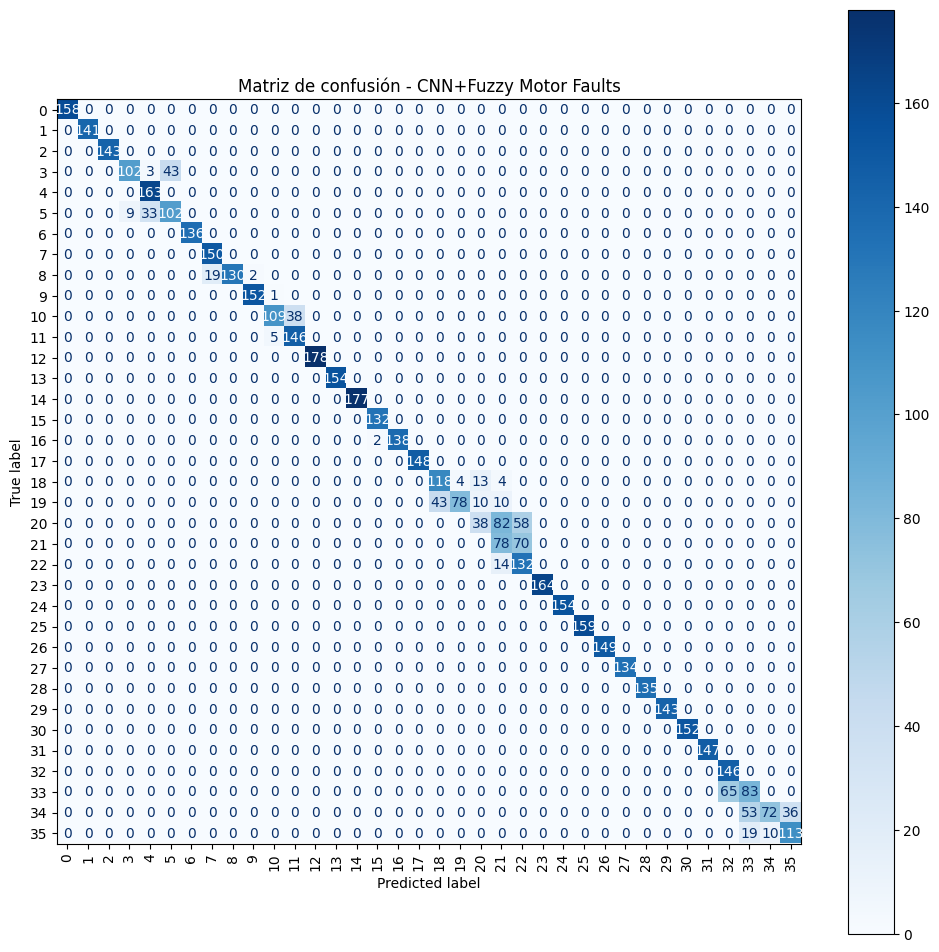

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# Evaluar en el set de validación
# =====================
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for vib, acoustic, ext, labels_batch in val_loader:
        vib, acoustic, ext = vib.to(device), acoustic.to(device), ext.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(vib, acoustic, ext)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Matriz de confusión - CNN+Fuzzy Motor Faults")
plt.show()


<Figure size 1600x1600 with 0 Axes>

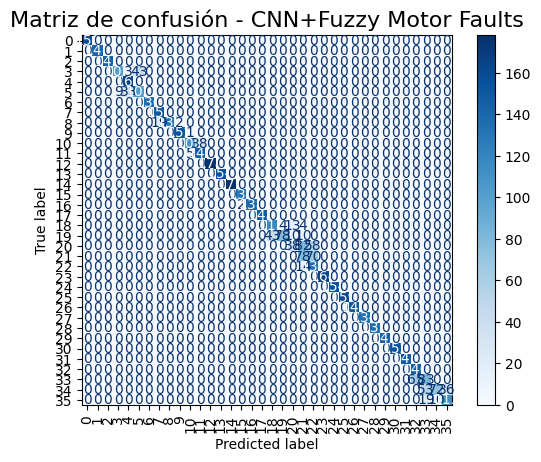

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Invertir el mapa de etiquetas
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[i] for i in range(num_classes)]

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

# Mostrar con nombres de clases
plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(include_values=True, cmap="Blues", colorbar=True, xticks_rotation=90)

plt.title("Matriz de confusión - CNN+Fuzzy Motor Faults", fontsize=16)
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import numpy as np

# Kappa global
kappa_global = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa (global): {kappa_global:.4f}")

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

# ==============================
# Kappa por clase
# ==============================
kappa_per_class = {}
for i in range(num_classes):
    # Construir etiquetas binarias: clase i vs no-i
    true_binary = (all_labels == i).astype(int)
    pred_binary = (all_preds == i).astype(int)

    kappa_class = cohen_kappa_score(true_binary, pred_binary)
    kappa_per_class[label_names[i]] = kappa_class

# Mostrar resultados
print("\nCohen's Kappa por clase:")
for clase, kappa_val in kappa_per_class.items():
    print(f"{str(clase):20s} : {kappa_val:.4f}")


Cohen's Kappa (global): 0.8770

Cohen's Kappa por clase:
0                    : 1.0000
1                    : 1.0000
2                    : 1.0000
3                    : 0.7825
4                    : 0.8971
5                    : 0.6978
6                    : 1.0000
7                    : 0.9386
8                    : 0.9233
9                    : 0.9899
10                   : 0.8279
11                   : 0.8676
12                   : 1.0000
13                   : 1.0000
14                   : 1.0000
15                   : 0.9923
16                   : 0.9926
17                   : 1.0000
18                   : 0.7806
19                   : 0.6937
20                   : 0.3063
21                   : 0.4473
22                   : 0.6377
23                   : 1.0000
24                   : 1.0000
25                   : 1.0000
26                   : 1.0000
27                   : 1.0000
28                   : 1.0000
29                   : 1.0000
30                   : 1.0000
31           

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Calcular el Cohen's Kappa
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.8770


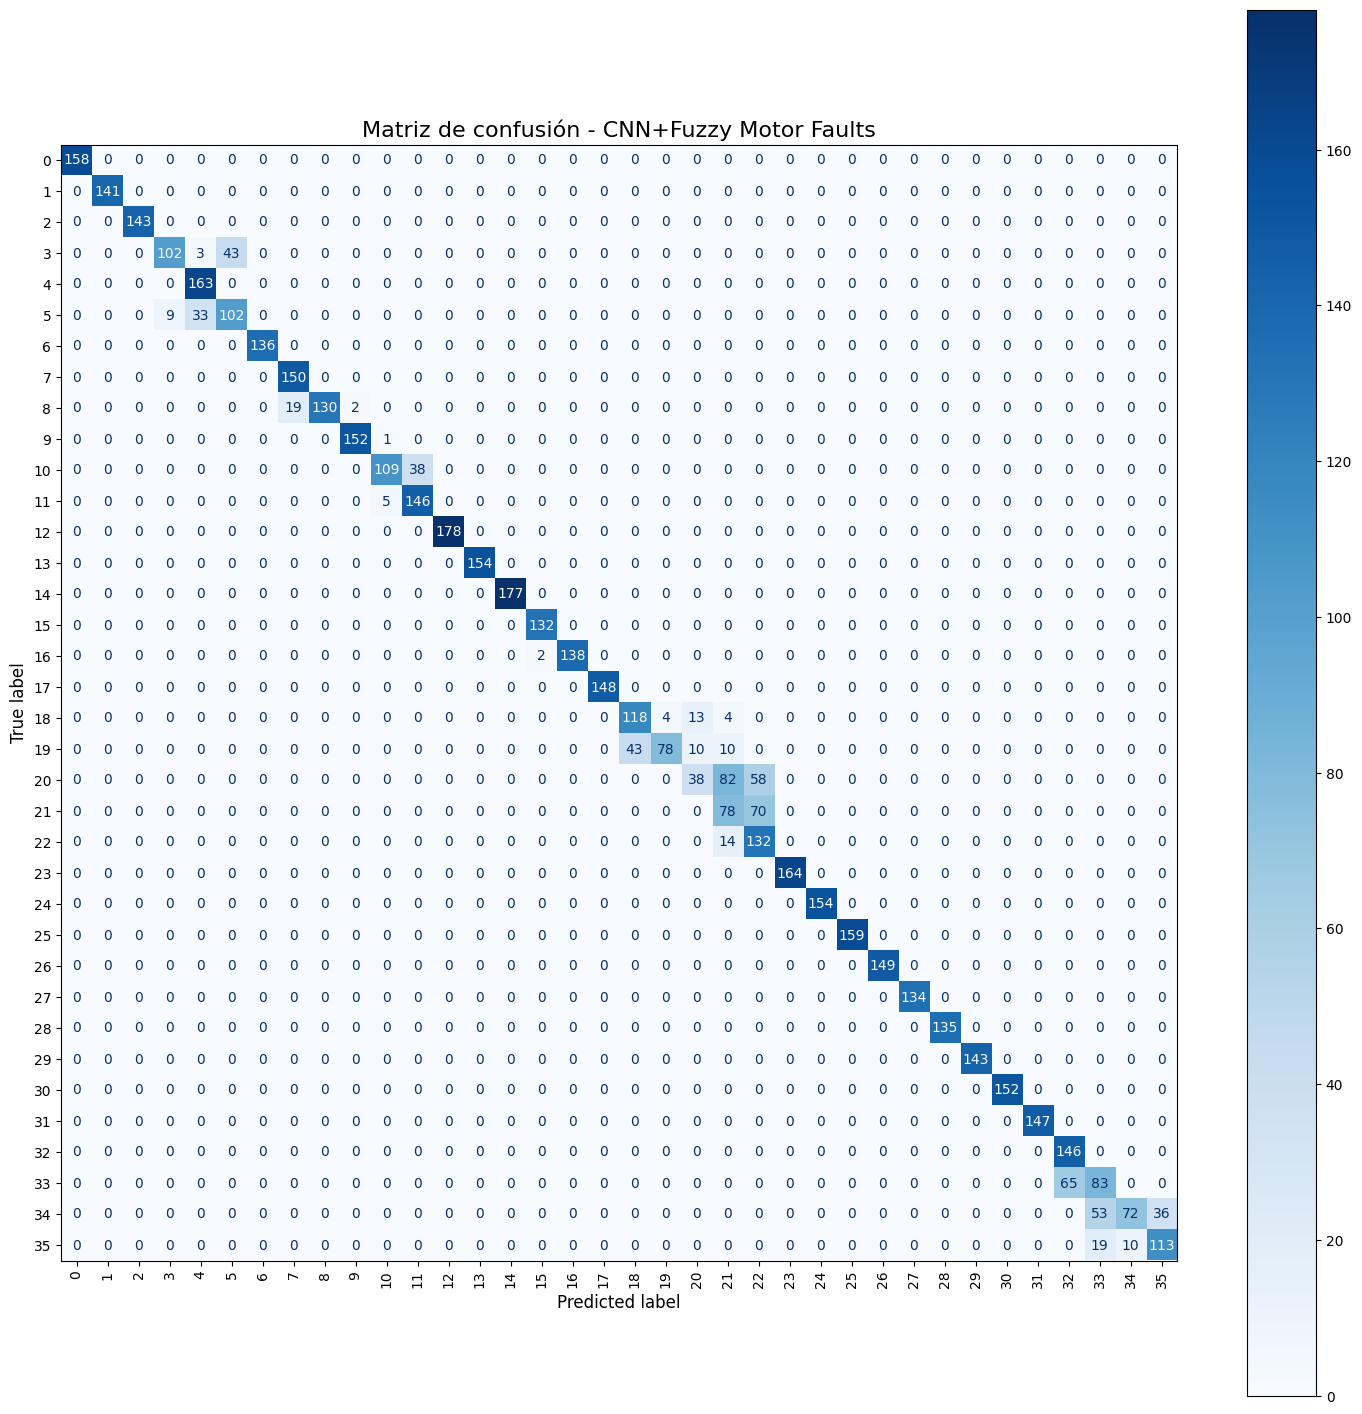

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# Crear lista de nombres de clase
# =====================
inv_label_map = {v: k for k, v in label_map.items()}  # invertir el diccionario
label_names = [inv_label_map[i] for i in range(num_classes)]  # ordenado según índice

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

# =====================
# Graficar con nombres de clase
# =====================
fig, ax = plt.subplots(figsize=(18, 18))  # tamaño grande para 36 clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)

plt.title("Matriz de confusión - CNN+Fuzzy Motor Faults", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()


NameError: name 'y' is not defined